<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/reinforcement_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

As illustrated in the figure below, investing bears a clear resemblance to game playing. In fact, some good poke players, such as Edward Thorp, also stand out in the stock markets.


![From Game Player to Stock Trader](https://files.gitbook.com/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F-MSGPuOMqasmUECLHyXj%2Fuploads%2Fgit-blob-87626e4bd747bdb40439277c09abce3e5aeb822d%2Fch5_rl_stock_trading.PNG?alt=media)

source: [Chapter Machine Learning](https://letianzj.gitbook.io/systematic-investing/products_and_methodologies/machine_learning)

Reinforcement learning has been applied to stock trading and portfolio management. Xiong, Zhuoran, et al (2018) explore the stock market and Zhang, et al (2020) trade the futures market. Nan, et al (2020) add news headline sentiments into the training. Spooner, Thomas, et al (2018) study the market makers who face inventory risk. Fischer, T. G. (2018) provides a survey of current reinforcement learning status in financial markets.



This notebook focuses on the trading part. It trains a reinforcement trader to buy and sell stocks. The objective is to achieve higher end dollar profits. Of course, other risk adjusted objectives such as Sharpe ratio are also viable.

The next notebook will focus on the portfolio management part, by training a reinforcement portfolio management to perform strategic allocation among stocks or asset classes.

It uses Gym-compatible [TensorTrade](https://github.com/tensortrade-org/tensortrade) TradingEnv.

## Setup

Install required packages and data.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


Install required packages. Uncomment to run once.

In [7]:
# !pip install -U ta
# !pip install -U tensortrade
# !pip install yfinance

In [11]:
import numpy as np
import pandas as pd
import ta
import yfinance as yf
from datetime import datetime

from tensortrade.env.default import actions, rewards
from tensortrade.env.generic.components.informer import Informer
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, Instrument
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default
from tensortrade.env.generic import TradingEnv
from tensortrade.agents import DQNAgent

Download stock price. Use adjusted price.

In [12]:
symbol = 'SPY'
start_date = datetime(2010, 1, 1)
end_date = datetime(2021, 6, 3)

df = yf.download(symbol, start=start_date, end=end_date)
df.sort_index(ascending=True, inplace=True)
df = df[start_date:end_date]
df['Open'] = df['Adj Close'] / df['Close'] * df['Open']
df['High'] = df['Adj Close'] / df['Close'] * df['High']
df['Low'] = df['Adj Close'] / df['Close'] * df['Low']
df['Volume'] = df['Adj Close'] / df['Close'] * df['Volume']
df['Close'] = df['Adj Close']
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
ta.add_all_ta_features(df, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)
df.columns = [symbol + ":" + name.lower() for name in df.columns]

[*********************100%***********************]  1 of 1 completed


In [13]:
df.head(2)

,SPY:open,SPY:high,SPY:low,SPY:close,SPY:volume,SPY:volume_adi,SPY:volume_obv,SPY:volume_cmf,SPY:volume_fi,SPY:volume_em,SPY:volume_sma_em,SPY:volume_vpt,SPY:volume_vwap,SPY:volume_mfi,SPY:volume_nvi,SPY:volatility_bbm,SPY:volatility_bbh,SPY:volatility_bbl,SPY:volatility_bbw,SPY:volatility_bbp,SPY:volatility_bbhi,SPY:volatility_bbli,SPY:volatility_kcc,SPY:volatility_kch,SPY:volatility_kcl,SPY:volatility_kcw,SPY:volatility_kcp,SPY:volatility_kchi,SPY:volatility_kcli,SPY:volatility_dcl,SPY:volatility_dch,SPY:volatility_dcm,SPY:volatility_dcw,SPY:volatility_dcp,SPY:volatility_atr,SPY:volatility_ui,SPY:trend_macd,SPY:trend_macd_signal,SPY:trend_macd_diff,SPY:trend_sma_fast,...,SPY:trend_dpo,SPY:trend_kst,SPY:trend_kst_sig,SPY:trend_kst_diff,SPY:trend_ichimoku_conv,SPY:trend_ichimoku_base,SPY:trend_ichimoku_a,SPY:trend_ichimoku_b,SPY:trend_stc,SPY:trend_adx,SPY:trend_adx_pos,SPY:trend_adx_neg,SPY:trend_cci,SPY:trend_visual_ichimoku_a,SPY:trend_visual_ichimoku_b,SPY:trend_aroon_up,SPY:trend_aroon_down,SPY:trend_aroon_ind,SPY:trend_psar_up,SPY:trend_psar_down,SPY:trend_psar_up_indicator,SPY:trend_psar_down_indicator,SPY:momentum_rsi,SPY:momentum_stoch_rsi,SPY:momentum_stoch_rsi_k,SPY:momentum_stoch_rsi_d,SPY:momentum_tsi,SPY:momentum_uo,SPY:momentum_stoch,SPY:momentum_stoch_signal,SPY:momentum_wr,SPY:momentum_ao,SPY:momentum_roc,SPY:momentum_ppo,SPY:momentum_ppo_signal,SPY:momentum_ppo_hist,SPY:momentum_kama,SPY:others_dr,SPY:others_dlr,SPY:others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600.0,1.113527e+08,118944600.0,0.936173,0.000000e+00,0.000000,0.000000,-5.622619e+07,112.743334,50.0,1000.000000,113.330002,113.330002,113.330002,0.000000,0.00,0.0,0.0,112.743334,114.623332,110.863337,3.335004,0.656029,0.0,0.0,111.510002,113.389999,112.450001,1.65887,0.968086,0.0,0.0,0.000000,0.000000,0.000000,113.330002,...,101.222657,-471.784677,-471.784677,0.000000,112.450001,112.450001,112.450001,112.450001,0.0,0.0,0.0,0.0,0.000000,212.860417,210.071869,4.0,4.0,0.0,-1.0,-1.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.000000,96.808636,96.808636,-3.191364,0.0,0.0,0.000000,0.00000,0.000000,113.330002,-47.178468,0.00000,0.00000
2010-01-05,113.260002,113.680000,112.849998,113.629997,111579900.0,2.094884e+08,230524500.0,0.908747,3.347346e+07,0.606247,0.606247,-5.582088e+07,113.054723,100.0,1002.647096,113.480000,113.779995,113.180004,0.528719,0.75,0.0,0.0,113.065000,114.419999,111.710000,2.396851,0.708486,0.0,0.0,111.510002,113.680000,112.595001,1.91223,0.976957,0.0,0.0,0.023931,0.004786,0.019145,113.480000,...,101.072659,-471.085559,-471.435118,0.349559,112.595001,112.595001,112.595001,112.595001,0.0,0.0,0.0,0.0,66.666667,212.860417,210.071869,8.0,4.0,4.0,-1.0,-1.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,28.782253,97.695710,97.252173,-2.304290,0.0,0.0,-0.496201,-0.09924,-0.396961,113.458942,0.264710,0.26436,0.26471


## Environment

### Exchange

In [14]:
exchange_name = "backtest-exchange"
exchange_options = ExchangeOptions(commission = 0.003, min_trade_size=1e-6)
exchange = Exchange(exchange_name, service=execute_order, options=exchange_options)(
    Stream.source(df[f'{symbol}:close'].tolist(), dtype="float").rename(f"USD-{symbol}")
)

### DataFeed

In [15]:
with NameSpace(exchange_name):
    streams = [Stream.source(df[c].tolist(), dtype="float").rename(c) for c in df.columns]
feed = DataFeed(streams)
feed.next()

{'backtest-exchange:/SPY:close': 113.33000183105469,
 'backtest-exchange:/SPY:high': 113.38999938964844,
 'backtest-exchange:/SPY:low': 111.51000213623047,
 'backtest-exchange:/SPY:momentum_ao': 0.0,
 'backtest-exchange:/SPY:momentum_kama': 113.33000183105469,
 'backtest-exchange:/SPY:momentum_ppo': 0.0,
 'backtest-exchange:/SPY:momentum_ppo_hist': 0.0,
 'backtest-exchange:/SPY:momentum_ppo_signal': 0.0,
 'backtest-exchange:/SPY:momentum_roc': 0.0,
 'backtest-exchange:/SPY:momentum_rsi': 100.0,
 'backtest-exchange:/SPY:momentum_stoch': 96.80863583791572,
 'backtest-exchange:/SPY:momentum_stoch_rsi': 0.0,
 'backtest-exchange:/SPY:momentum_stoch_rsi_d': 0.0,
 'backtest-exchange:/SPY:momentum_stoch_rsi_k': 0.0,
 'backtest-exchange:/SPY:momentum_stoch_signal': 96.80863583791572,
 'backtest-exchange:/SPY:momentum_tsi': 0.0,
 'backtest-exchange:/SPY:momentum_uo': 0.0,
 'backtest-exchange:/SPY:momentum_wr': -3.1913641620842887,
 'backtest-exchange:/SPY:open': 112.37000274658203,
 'backtest-ex

### Portfolio

In [16]:
SPY = Instrument(symbol, 1, symbol)
portfolio = Portfolio(USD, [
    Wallet(exchange, 1_000_000 * USD),
    Wallet(exchange, 0 * SPY),
])

TradingEnv

In [17]:
env = default.create(
    portfolio=portfolio,
    action_scheme=default.actions.SimpleOrders(trade_sizes=[1.0], min_order_pct=0),       # 100% buy or sell
    reward_scheme=default.rewards.SimpleProfit(window_size=1),
    feed=feed,
    renderer=default.renderers.ScreenLogger(date_format="%Y-%m-%d %H:%M:%S %p"),
    window_size=22
)

## Training

### Ramdom Trading

In [18]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

In [19]:
portfolio.ledger.as_frame().head(20)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange:USD/free,backtest-exchange:USD/locked,LOCK (LOCK FOR ORDER),1000000.00 USD,0.00 USD,1000000.00 USD,1000000.00 USD
1,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange:USD/locked,backtest-exchange,WITHDRAWAL (COMMISSION),3000.00 USD,0.00 USD,997000.00 USD,997000.00 USD
2,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange:USD/locked,backtest-exchange,WITHDRAWAL (FILL ORDER),997000.00 USD,0.00 USD,0.00 USD,0.00 USD
3,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange,backtest-exchange:SPY/locked,DEPOSIT (TRADED 997000.00 USD backtest-exchang...,8767.9 SPY,0.0 SPY,8767.9 SPY,8767.9 SPY
4,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange:USD/locked,backtest-exchange:USD/free,UNLOCK USD (COMPLETED),0.00 USD,0.00 USD,0.00 USD,0.00 USD
5,6372a259-d1fa-441f-8555-13e5f747c691,3,backtest-exchange:SPY/locked,backtest-exchange:SPY/free,UNLOCK SPY (COMPLETED),8767.9 SPY,8767.9 SPY,0.0 SPY,0.0 SPY
6,a5225e8c-7ebd-46ea-9f2a-13cd612e8799,9,backtest-exchange:SPY/free,backtest-exchange:SPY/locked,LOCK (LOCK FOR ORDER),8700.9 SPY,67.0 SPY,8700.9 SPY,8700.9 SPY
7,a5225e8c-7ebd-46ea-9f2a-13cd612e8799,9,backtest-exchange:SPY/locked,backtest-exchange,WITHDRAWAL (COMMISSION),26.1 SPY,67.0 SPY,8674.8 SPY,8674.8 SPY
8,a5225e8c-7ebd-46ea-9f2a-13cd612e8799,9,backtest-exchange:SPY/locked,backtest-exchange,WITHDRAWAL (FILL ORDER),8674.8 SPY,67.0 SPY,0.0 SPY,0.0 SPY
9,a5225e8c-7ebd-46ea-9f2a-13cd612e8799,9,backtest-exchange,backtest-exchange:USD/locked,DEPOSIT (TRADED 8674.8 SPY backtest-exchange:U...,996994.76 USD,0.00 USD,996994.76 USD,996994.76 USD


### DQN Agent

In [22]:
obs = env.reset()
agent = DQNAgent(env)
agent.train(n_episodes=2, n_steps=2000, render_interval=200)

====      AGENT ID: c730a044-bc18-44c9-bb12-b2cfaa715ebc      ====
[2021-12-12 03:15:40 AM] Episode: 1/2 Step: 201/2000
[2021-12-12 03:16:11 AM] Episode: 1/2 Step: 401/2000
[2021-12-12 03:16:43 AM] Episode: 1/2 Step: 601/2000
[2021-12-12 03:17:15 AM] Episode: 1/2 Step: 801/2000
[2021-12-12 03:17:47 AM] Episode: 1/2 Step: 1001/2000
[2021-12-12 03:18:20 AM] Episode: 1/2 Step: 1201/2000
[2021-12-12 03:18:52 AM] Episode: 1/2 Step: 1401/2000
[2021-12-12 03:19:24 AM] Episode: 1/2 Step: 1601/2000
[2021-12-12 03:19:56 AM] Episode: 1/2 Step: 1801/2000
[2021-12-12 03:20:28 AM] Episode: 1/2 Step: 2001/2000
[2021-12-12 03:21:00 AM] Episode: 2/2 Step: 201/2000
[2021-12-12 03:21:32 AM] Episode: 2/2 Step: 401/2000
[2021-12-12 03:22:04 AM] Episode: 2/2 Step: 601/2000
[2021-12-12 03:22:36 AM] Episode: 2/2 Step: 801/2000
[2021-12-12 03:23:08 AM] Episode: 2/2 Step: 1001/2000
[2021-12-12 03:23:41 AM] Episode: 2/2 Step: 1201/2000
[2021-12-12 03:24:13 AM] Episode: 2/2 Step: 1401/2000
[2021-12-12 03:24:44 AM

0.0005538603331005586

## Performance

In [23]:
performance = pd.DataFrame.from_dict(portfolio.performance, orient='index')

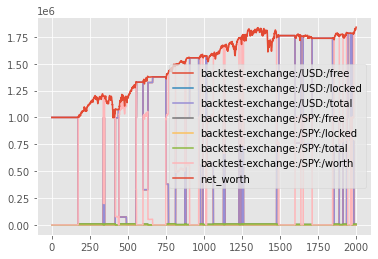

In [24]:
performance.plot()

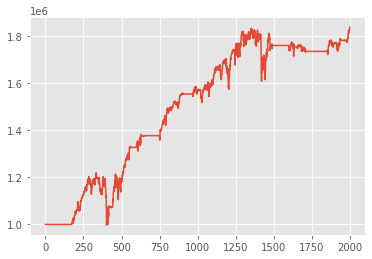

In [25]:
performance.net_worth.plot()